In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

In [15]:
# --- Configuration ---
filename = "cw_rx_mixed.dat"  # Path to your saved binary file
sample_rate = 100e3            # Original sample rate
decimation = 1            # Your decimation factor
fs = sample_rate / decimation  # Effective sampling rate

# --- Load Data ---
data = np.fromfile(filename, dtype=np.complex64)

# --- Phase Extraction ---
phase_raw = np.unwrap(np.angle(data))

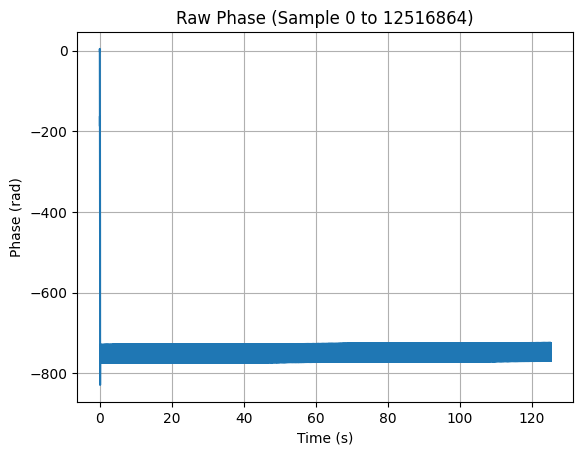

In [16]:
# --- Raw Phase Data ---
# Create time axis in seconds
# time_axis = np.arange(num_samples) / fs
# segment = phase_raw[start_index:start_index + num_samples]
time_axis = np.arange(len(phase_raw)) / fs
plt.plot(time_axis, phase_raw)
plt.title(f"Raw Phase (Sample 0 to {len(phase_raw)})")
plt.xlabel("Time (s)")
plt.ylabel("Phase (rad)")
plt.grid()
plt.show()


In [87]:
# --- Frequency Analysis ---
def compute_peak_freq(signal, low, high, fs):
    N = len(signal)
    if N == 0:
        return 0.0, np.array([]), np.array([])
    window = np.hanning(N)
    spectrum = np.fft.fft(signal * window)
    freqs = np.fft.fftfreq(N, 1 / fs)
    mask = (freqs > low) & (freqs < high)
    if not np.any(mask):
        return 0.0, np.array([]), np.array([])
    peak_freq = freqs[mask][np.argmax(np.abs(spectrum[mask]))]
    return peak_freq, freqs[mask], spectrum[mask]

In [55]:
br_freq, br_freqs, br_spectrum = compute_peak_freq(breathing_signal, 0.1, 0.7, fs)
hr_freq, hr_freqs, hr_spectrum = compute_peak_freq(heart_signal, 0.8, 3.0, fs)


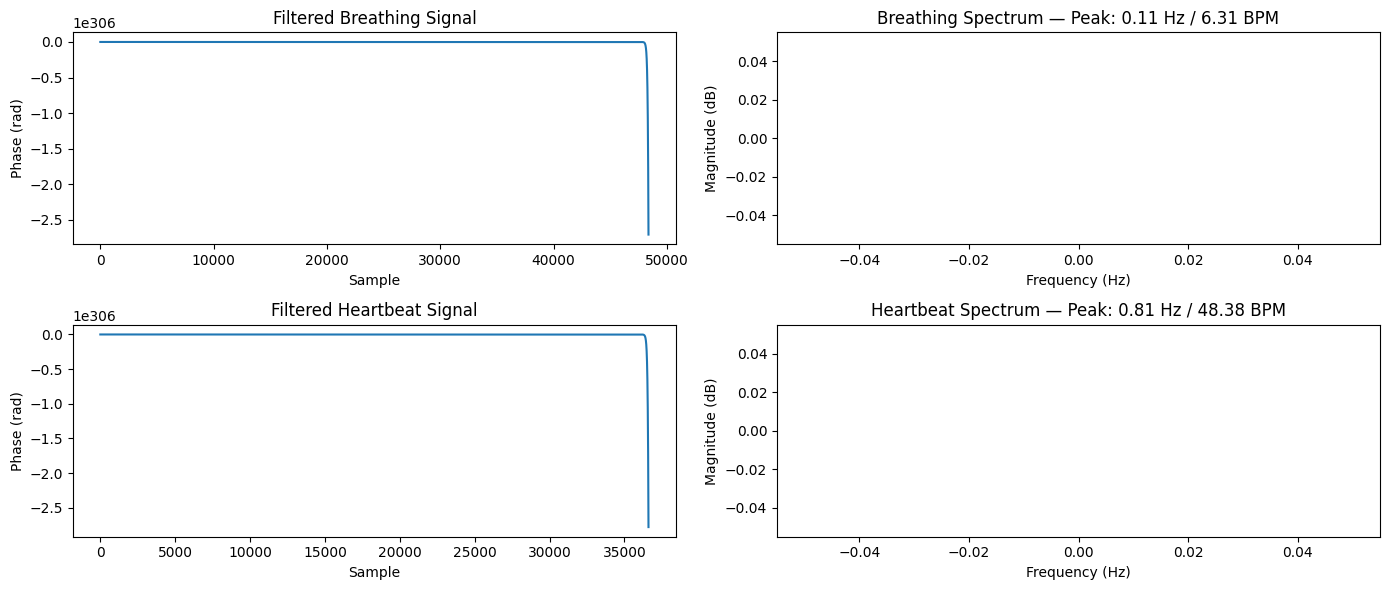

In [88]:
# --- Plot ---
plt.figure(figsize=(14, 6))

plt.subplot(2, 2, 1)
plt.plot(breathing_signal)
plt.title("Filtered Breathing Signal")
plt.xlabel("Sample")
plt.ylabel("Phase (rad)")

plt.subplot(2, 2, 2)
if len(br_freqs) > 0:
    plt.plot(br_freqs, 20 * np.log10(np.abs(br_spectrum)))
    plt.title(f"Breathing Spectrum — Peak: {br_freq:.2f} Hz / {br_freq*60:.2f} BPM")
else:
    plt.title("Breathing Spectrum (No valid peak)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")

plt.subplot(2, 2, 3)
plt.plot(heart_signal)
plt.title("Filtered Heartbeat Signal")
plt.xlabel("Sample")
plt.ylabel("Phase (rad)")

plt.subplot(2, 2, 4)
if len(hr_freqs) > 0:
    plt.plot(hr_freqs, 20 * np.log10(np.abs(hr_spectrum)))
    plt.title(f"Heartbeat Spectrum — Peak: {hr_freq:.2f} Hz / {hr_freq*60:.2f} BPM")
else:
    plt.title("Heartbeat Spectrum (No valid peak)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()

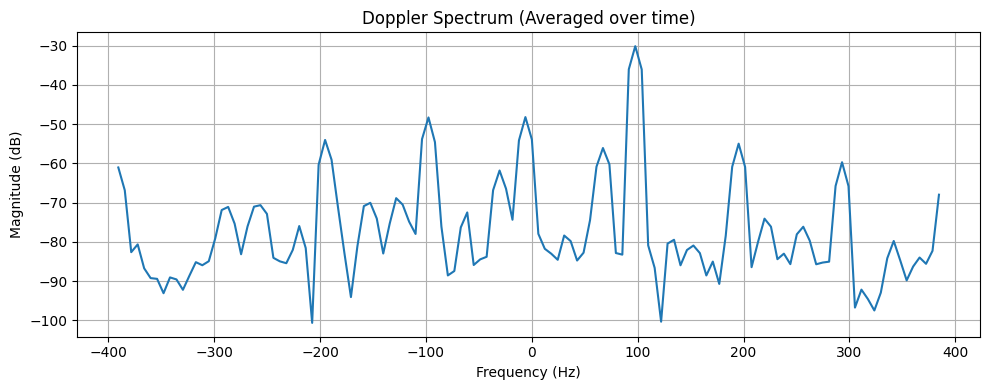

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def doppler_fft(signal, pulses_per_frame=64, window_fn=np.hanning):
    """
    Computes a Doppler FFT on a complex CW signal stream.
    
    Parameters:
    - signal: 1D numpy array of complex samples (raw IQ data)
    - pulses_per_frame: number of samples per Doppler processing window
    - window_fn: window function to apply (e.g. np.hanning)

    Returns:
    - doppler_map (2D np.array): Doppler spectrum (frame count x Doppler bins)
    - doppler_freqs (1D np.array): Doppler frequency axis in Hz
    """
    # Reshape into (frames, pulses_per_frame)
    num_frames = len(signal) // pulses_per_frame
    signal = signal[:num_frames * pulses_per_frame]
    frames = signal.reshape((num_frames, pulses_per_frame))

    # Optional: remove mean (DC component)
    frames = frames - np.mean(frames, axis=1, keepdims=True)

    # Apply window along pulses
    window = window_fn(pulses_per_frame)
    windowed = frames * window

    # Doppler FFT along slow-time axis (rows)
    doppler_fft_out = np.fft.fftshift(np.fft.fft(windowed, axis=1), axes=1)

    # Generate frequency axis
    fs = 100e3  # change to your actual sampling rate after decimation
    prt = pulses_per_frame / fs  # Pulse Repetition Time
    doppler_freqs = np.fft.fftshift(np.fft.fftfreq(pulses_per_frame, d=prt))

    return doppler_fft_out, doppler_freqs

# --- Example Usage ---
doppler_map, doppler_freqs = doppler_fft(data, pulses_per_frame=128)

# Plot averaged Doppler spectrum
plt.figure(figsize=(10, 4))
plt.plot(doppler_freqs, 20 * np.log10(np.abs(np.mean(doppler_map, axis=0))))
plt.title("Doppler Spectrum (Averaged over time)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.tight_layout()
plt.show()


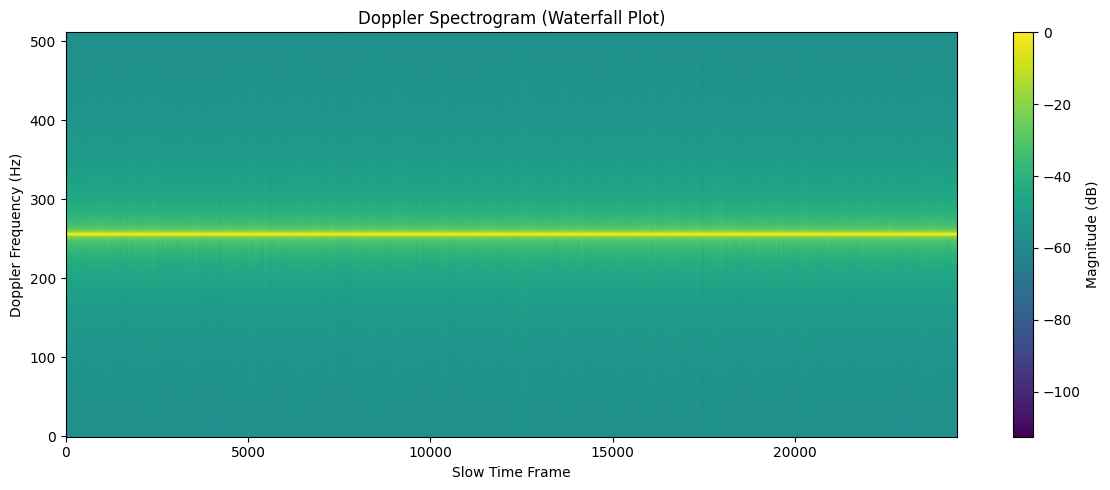

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def bandpass_filter_complex(signal, lowcut, highcut, fs, order=4):
    from scipy.signal import butter, filtfilt
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    real = filtfilt(b, a, signal.real)
    imag = filtfilt(b, a, signal.imag)
    return real + 1j * imag


def highpass_filter_complex(signal, cutoff=0.2, fs=100.0, order=4):
    """High-pass filter applied separately to real and imag parts of a complex signal."""
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='high', analog=False)

    real_filtered = filtfilt(b, a, signal.real)
    imag_filtered = filtfilt(b, a, signal.imag)

    return real_filtered + 1j * imag_filtered


def doppler_fft(signal, pulses_per_frame=256, window_fn=np.hanning, fs=100e3):
    """
    Computes Doppler FFT with optional high-pass filtering and spectrogram.

    Parameters:
    - signal: complex IQ data (1D np.array)
    - pulses_per_frame: slow-time FFT size
    - window_fn: window function for FFT (e.g., np.hanning)
    - fs: sampling rate after decimation (Hz)

    Returns:
    - doppler_map (2D np.array): (num_frames x doppler bins)
    - doppler_freqs (1D np.array): Doppler frequency axis (Hz)
    """
    # Ensure signal is a multiple of pulses_per_frame
    num_frames = len(signal) // pulses_per_frame
    signal = signal[:num_frames * pulses_per_frame]
    frames = signal.reshape((num_frames, pulses_per_frame))
    frames = frames - np.mean(frames, axis=1, keepdims=True)

    # Apply window along slow-time dimension
    doppler_window = window_fn(pulses_per_frame)
    windowed = frames * doppler_window
    
    # High pass filter
    # hpf_filtered = bandpass_filter_complex(windowed, 0.5, 1.0, fs)
    # Apply bandpass filter row-by-row
    filtered_frames = np.array([
        bandpass_filter_complex(row, 1.0, 100.0, fs)
        for row in windowed
    ])

    # Perform Doppler FFT along pulses (axis=1)
    doppler_fft_raw = np.fft.fft(filtered_frames, axis=1)
    doppler_fft_shifted = np.fft.fftshift(doppler_fft_raw, axes=1)

    # Compute Doppler frequency axis
    prt = pulses_per_frame / fs  # Pulse Repetition Time (s)
    doppler_freqs = np.fft.fftshift(np.fft.fftfreq(pulses_per_frame, d=prt))  # Hz

    return doppler_fft_shifted, doppler_freqs



# --- Load your complex data (already done externally) ---
fs = 100e3 

doppler_map, doppler_freqs = doppler_fft(data, pulses_per_frame=512, window_fn=np.blackman, fs=fs)
doppler_map_db = 20 * np.log10(np.abs(doppler_map) / np.max(np.abs(doppler_map), axis=1, keepdims=True) + 1e-12)


# --- Spectrogram Plot ---
plt.figure(figsize=(12, 5))
# plt.imshow(
#     20 * np.log10(np.abs(doppler_map.T) + 1e-12),  # transpose for time vs freq
#     aspect='auto',
#     extent=[0, doppler_map.shape[0], doppler_freqs[0], doppler_freqs[-1]],
#     origin='lower',
#     cmap='viridis'
# )
plt.imshow(
    doppler_map_db.T,
    aspect='auto',
    origin='lower',
    cmap='viridis'
)

plt.colorbar(label='Magnitude (dB)')
plt.xlabel("Slow Time Frame")
plt.ylabel("Doppler Frequency (Hz)")
plt.title("Doppler Spectrogram (Waterfall Plot)")
# plt.ylim(-5, 5)  # or (-5, 5) if you care about direction
plt.tight_layout()
plt.show()


In [20]:
test = data.copy()

In [21]:
test.shape

(12516864,)

In [22]:
num_frames = len(data) // 512 

In [23]:
num_frames

24447

In [24]:
pulses_per_frame = 512
num_frames = len(test) // pulses_per_frame


In [25]:
num_frames

24447

In [26]:
signal = test[:num_frames * pulses_per_frame]

In [28]:
frames = signal.reshape((num_frames, pulses_per_frame))

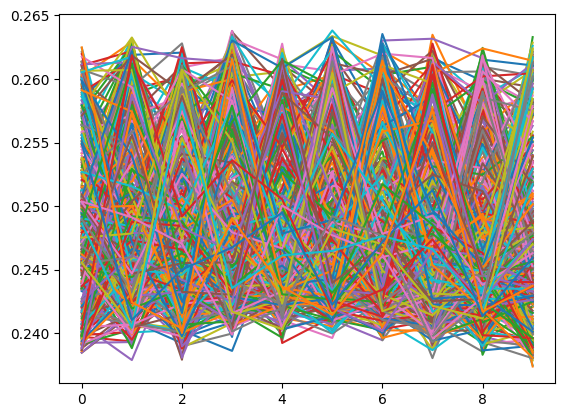

In [35]:
plt.plot(abs(frames[5000:5010]))

In [ ]:
frames = frames - np.mean(frames, axis=1, keepdims=True)